## Using Financial Fundamentals Data to forecast EPS

### Multi-variable linear models via scikit-learn and statsmodels
In this example you will be be using various financial fundamentals data to predict future Earning Per Share (EPS).
In this exercise you will be using linear regression model. The dataset is quarterly time series of various financial fundamentals.
In particular, the dataset has the following columns:
* __cogsq__	cost of good sold
* __cshoq__	common shares outstanding
* __cshpry__ common shares used for calculating EPS
* __cshprq__ common shares used for calculating EPS
* __epspiq__ earnings per share (dilluted) including extraordinary items
* __epspxq__ earnings per share (dilluted) excluding extraordinary items
* __invtq__	inventories
* __rectq__	account receivables
* __saleq__	net sales - Sales/Turnover (Net) Turnover is the net sales generated by a business, while profit is the residual earnings of a business after all expenses have been charged against net sales. Thus, turnover and profit are essentially the beginning and ending points of the income statement - the top-line revenues and the bottom-line results
* __xsgaq__	administrative expense
* __piq__ Pretax Income
* __txtq__ Income taxes total
* __txpdy__	Income taxes paid
* __prccq__	capital expenditures
* __revtq__ Revenue Total

Through series of examples in this notebook you will learn how to use both scikit-learn and statsmodels to train a linear model.

In [1]:
%pylab inline
import os.path
import pandas as pd
from pymlfin.util.util import get_eps_data

print(os.getcwd())
df = get_eps_data('MSFT')
df.reset_index(level=0, inplace=True) # remove GVKEY
df.loc[:,('EPS_t1', 'EPS_t4', 'INV_t1', 'AR_t1', 'SA_t1', 'GM_t1', 'CAPX_t1', 'ETR_t1', 'EPS')].head()

Populating the interactive namespace from numpy and matplotlib
/Users/igorhalperin/home/Python/Coursera_ML/NYU/mlfin


,EPS_t1,EPS_t4,INV_t1,AR_t1,SA_t1,GM_t1,CAPX_t1,ETR_t1,EPS
datadate,,,,,,,,,
1987-06-30,0.69,0.42,0.516249,2.074071,1.379797,2.617770,0.624669,0.444283,0.62
1987-09-30,0.62,0.57,0.597956,1.991295,1.664993,2.621289,2.095536,0.337975,0.38
1987-12-31,0.38,0.71,0.414236,1.005384,0.931504,1.515684,0.190183,0.345454,0.63
1988-03-31,0.63,0.69,0.514385,1.488524,1.160860,2.147013,0.413706,0.342557,0.67
1988-06-30,0.67,0.62,0.767657,1.540407,1.237758,2.228054,0.698531,0.317291,0.54


### The M2.1 by Lorek and Willinger (1996)
In the following cell we will train and test out of sample multi-variable model M2.1 by Lorek and Willinger (1996). The model has the following spceification:
$$EPS_t = \alpha + \beta_1 EPS_{t-1} + \beta_2 EPS_{t-4} + \beta_3 INV_{t-1} + \beta_4 AR{t-1} + \beta_5 CAPX_{t-1}  + \beta_6 GM_{t-1} + \beta_7 SA_{t-1} + \beta_8 ETR_{t-1} + \beta_9 LF_{t-1} + \epsilon_t$$
Due to the lack of data for number of employees we will be using abbreviated version of Lorek and Willinger model which excludes $\beta_9 LF_{t-1}$ term.
The terms on the right hand side as customary are called predictors and correspond to the columns in df data frame.

In [2]:
# M2.1 by Lorek and Willinger (1996)
# E(EPS[t]) = alpha + beta_1 *EPS[t-1] + beta_2*EPS[t-4] +
# beta_3 * INV[t-1] + beta_4 * AR[t-1] + beta_5 * CAPX[t-1] + beta_6 *GM[t-1] +
# beta_7 * SA[t-1] + beta_8 * ETR[t-1] + beta9 * LF[t-1] + epsilon_t

eps_df = pd.DataFrame(df['EPS'].values, columns=['EPS'], index=df.index)
predictors_df = df.loc[:, ('EPS_t1', 'EPS_t4', 'INV_t1', 'AR_t1', 'CAPX_t1', 'GM_t1', 'SA_t1', 'ETR_t1')]

In this exercise we will be using both scikit-learn and  statsmodels to train the model. First, we will train the model using scikit-learn and test it out-of-sample. Then we will use statsmodels to fit the same model. We will use  sklearn.model_selection.TimeSeriesSplit class to partition the original time series data into training and test data sets.

/Users/igorhalperin/anaconda/envs/py36-test/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


M2.1 Lorek and Willinger (1996) via scikit-learn
training data set has 41 observations from 1987-06-30 to 1997-06-30
model coefficients: [[ 1.03647099  0.09328008 -0.24930418  0.17806657 -0.18108243 -0.67058393
   0.95034594 -1.49187651]]
model intercept: 0.7729
scikit-learn in-sample RMSE = 0.1203
scikit-learn out-of-sample RMSE = 0.2919
M2.1 Lorek and Willinger (1996) via scikit-learn
training data set has 80 observations from 1987-06-30 to 2007-03-31
model coefficients: [[  3.98571236e-01   2.85126910e-01   2.63514962e-04   3.13690192e-02
   -1.16365064e-01  -2.15001048e-01   5.37484362e-01   5.30088650e-01]]
model intercept: -0.1125
scikit-learn in-sample RMSE = 0.1346
scikit-learn out-of-sample RMSE = 0.3162


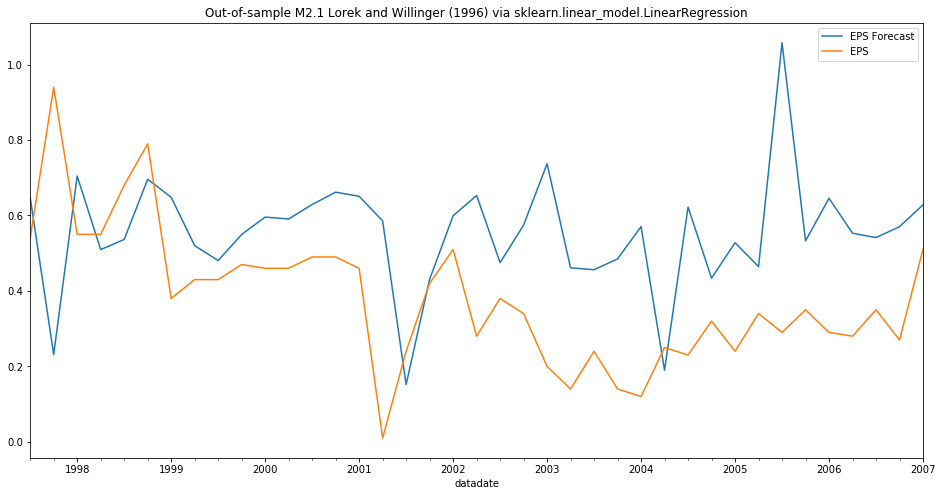

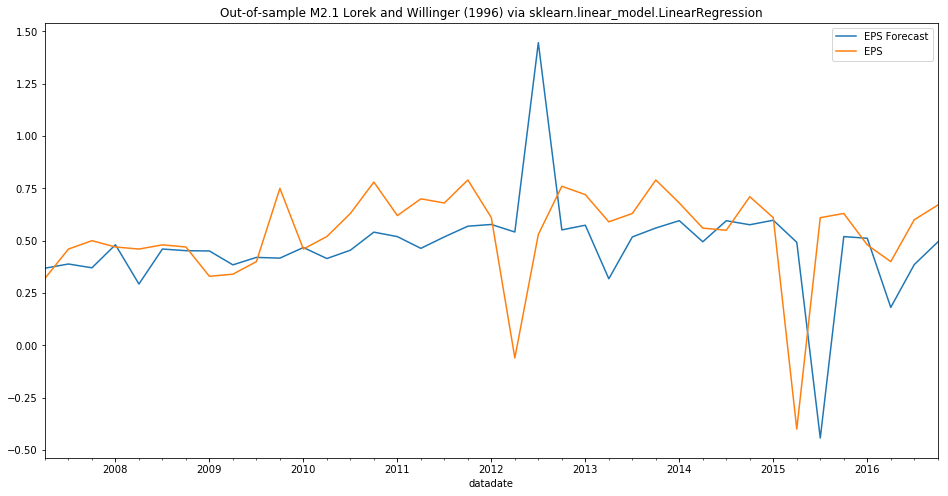

In [3]:
import statsmodels.formula.api as sm
import statsmodels.api as sm_api
import sklearn
import sklearn.model_selection
import sklearn.linear_model
import matplotlib.dates

n_splits = 2
tscv = sklearn.model_selection.TimeSeriesSplit(n_splits=n_splits)
for train_index, test_index in tscv.split(predictors_df):
    predict_train, predict_test = predictors_df.loc[predictors_df.index[train_index]], \
                                  predictors_df.loc[predictors_df.index[test_index]]
    eps_train, eps_test = eps_df.loc[eps_df.index[train_index]], \
                          eps_df.loc[eps_df.index[test_index]]

    lm_lorek = sklearn.linear_model.LinearRegression().fit(predict_train, eps_train)
    print("M2.1 Lorek and Willinger (1996) via scikit-learn")
    print("training data set has %d observations from %s to %s" % (len(predict_train.index), 
                                                                   predict_train.index[0].strftime('%Y-%m-%d'),
                                                                   predict_train.index[-1].strftime('%Y-%m-%d')))
    print("model coefficients: %s" % lm_lorek.coef_)
    print("model intercept: %.4f" % lm_lorek.intercept_[0])
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(eps_train, lm_lorek.predict(predict_train)))
    print("scikit-learn in-sample RMSE = %.4f" % rmse)

    eps_forecast = lm_lorek.predict(predict_test)
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(eps_test, eps_forecast))
    print("scikit-learn out-of-sample RMSE = %.4f" % rmse)

    eps_forecast = pd.DataFrame(eps_forecast, index=eps_test.index, columns=('EPS Forecast',))
    comb = pd.concat([eps_forecast, eps_test], axis=1, join='inner')
    comb.rename(columns={0: 'EPS Forecast'}, inplace=True)
    comb.describe()
    ax = comb.plot(title='Out-of-sample M2.1 Lorek and Willinger (1996) via sklearn.linear_model.LinearRegression', 
                   figsize=(16, 8))


#### M2.1 Lorek and Willinger (1996) via scikit-learn
What we have observed from running out-of-sample forecast? For once, the quality of the forecast for such long time frames is rather poor. Also, model parameters change quite a bit, depending on the training data set. In addition, sklearn.linear_model.LinearRegression does not provide us with much information about the quality of the fit except for Mean Square Error (MSE). By definition MSE is:
$$ MSE = \frac{1}{n} \sum_{i=0}^{n-1} (y_i - \hat{y}_i)^2$$

Next, we try fitting the same model of Lorek and Willinger, but this time using python statsmodels package. For readability, we cache data frame that contain forecasted and actual time series and display those graphs later.

In [4]:
results = [None] * n_splits
ix = 0
for train_index, test_index in tscv.split(predictors_df):
    predict_train, predict_test = predictors_df.loc[predictors_df.index[train_index]], \
                                  predictors_df.loc[predictors_df.index[test_index]]
    eps_train, eps_test = eps_df.loc[eps_df.index[train_index]], \
                          eps_df.loc[eps_df.index[test_index]]

    # fit stats models multi-variable linear regression model
    model_lorek = sm.OLS(eps_train, predict_train).fit()
    print("M2.1 Lorek and Willinger (1996) via stats models")
    print("training data set has %d observations from %s to %s" % (len(predict_train.index), 
                                                                   predict_train.index[0].strftime('%Y-%m-%d'),
                                                                   predict_train.index[-1].strftime('%Y-%m-%d')))
    print(model_lorek.summary())

    # make prediction
    eps_forecast = model_lorek.predict(predict_test)

    # compute root mean squared error of the forecasts
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(eps_test, eps_forecast))
    print("stats models out-of-sample RMSE = %.4f" % rmse)

    comb = pd.concat([eps_forecast, eps_test], axis=1, join='inner')
    comb.rename(columns={0: 'EPS Forecast'}, inplace=True)
    results[ix]= comb
    ix += 1

M2.1 Lorek and Willinger (1996) via stats models
training data set has 41 observations from 1987-06-30 to 1997-06-30
                            OLS Regression Results                            
Dep. Variable:                    EPS   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     165.0
Date:                Sat, 23 Sep 2017   Prob (F-statistic):           2.41e-24
Time:                        16:41:39   Log-Likelihood:                 27.565
No. Observations:                  41   AIC:                            -39.13
Df Residuals:                      33   BIC:                            -25.42
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------

statsmodels.OLS provides much more information about the model than scikit-learn does. Specifically, in addition to providing model coefficients, statsmodels provides statistical significance of these coefficients. The statistical siginificance of each coefficient is report in $P >|t|$ column. A value smaller than 0.05 indicates that the coeffcient is significantly different from zero. Examining the results we observe that coeffcients $EPS_{t-4}$, $CAPX_{t-1}$, $SA_{t-1}$ are siginificantly different from zero, while the rest of the coeffcients are not and could be dropped from the model specification.

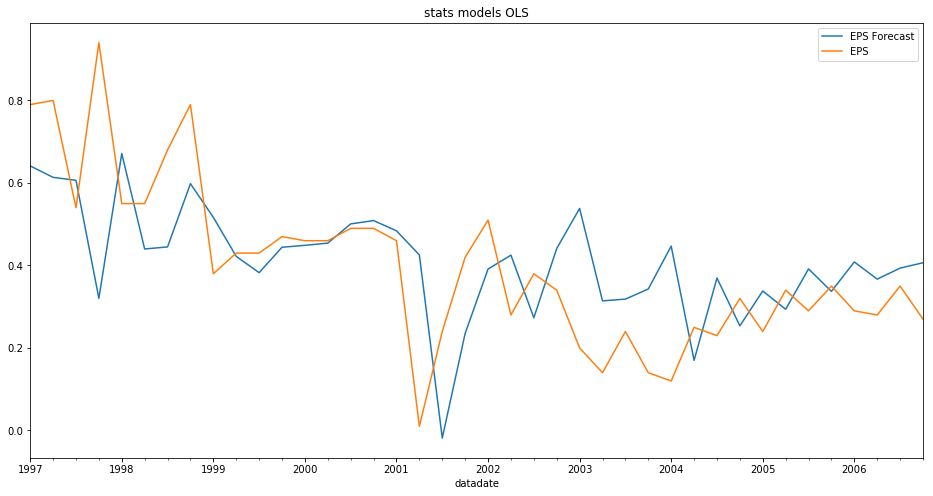

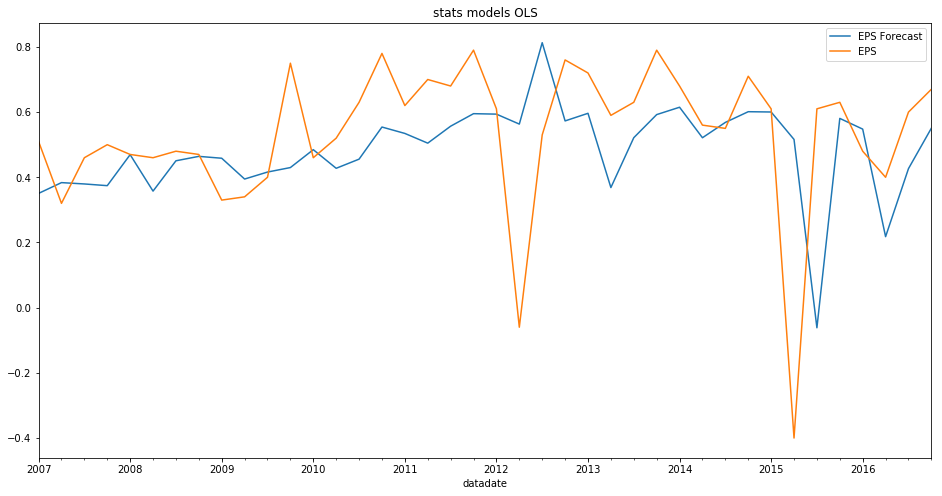

In [36]:
for comb in results:
    comb.describe()
    comb.plot(title='stats models OLS', figsize=(16, 8))

Clearly, linear models are nor capabale of generalizing well over extended period of time. In the code that follows we will use longer training periods and shorter (up to 1 year) test periods and see if linear models can deliver better out of sample fit.